In [1]:
import pandas as pd
from src.core.Processing import Processing
from src.core.Analyser import Analyser
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
file_path="/home/khaldi/Documents/data_app_machine/bank-additional-full.csv"
sep=";"
outcome="y"
positive_mod="yes"

In [3]:
df=pd.read_csv(file_path,sep=sep)

In [4]:
process=Processing() # object which do processing for df
analyzer=Analyser() #object which give graphics, statistics indicators for df

In [5]:
df.shape

(41188, 21)

In [6]:
process.summary(df)

{'Missing Values': age               0
 job               0
 marital           0
 education         0
 default           0
 housing           0
 loan              0
 contact           0
 month             0
 day_of_week       0
 duration          0
 campaign          0
 pdays             0
 previous          0
 poutcome          0
 emp.var.rate      0
 cons.price.idx    0
 cons.conf.idx     0
 euribor3m         0
 nr.employed       0
 y                 0
 dtype: int64,
 'Constant Features': []}

The dimension of the dataframe is (41188,21).
We can see that they don't have any missing values and constant features

no     0.887346
yes    0.112654
Name: y, dtype: float64

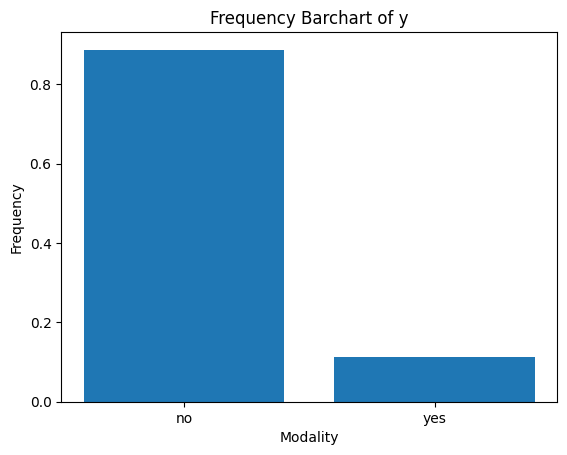

In [7]:
fig,ax=plt.subplots()
analyzer.bar_chart(df,outcome,ax,with_proportion=True)

We can see above that, Attrition attribute is imbalanced ( 36548 (~94%) rows for "no" modality and 4640 (~5.4%) for "yes" modality)

In [8]:
analyzer_summary=analyzer.summary(df)
quantitatives,qualitatives=analyzer_summary["features"]["quantitative_columns"],analyzer_summary["features"]["qualitative_columns"]

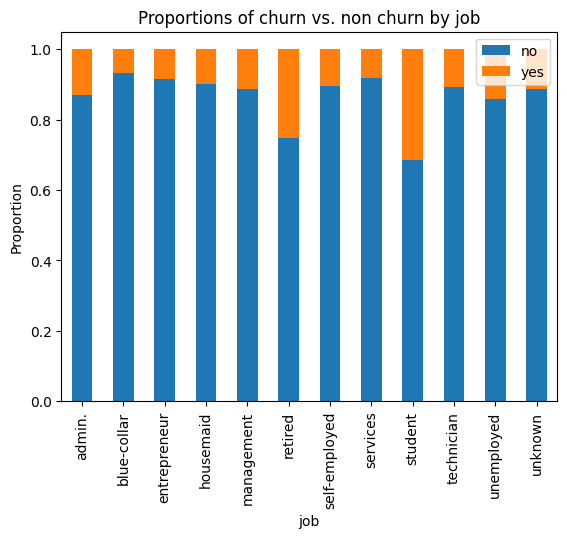

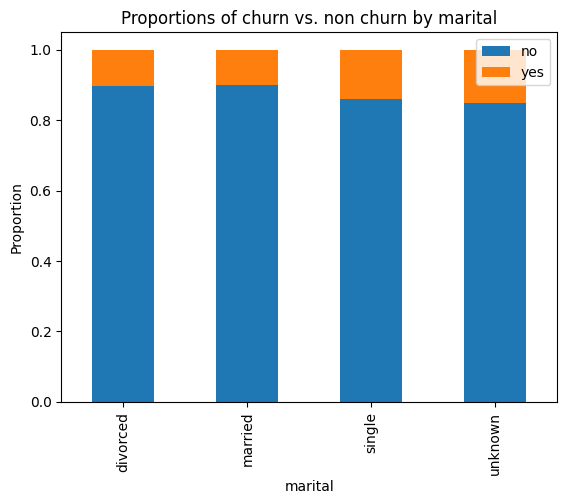

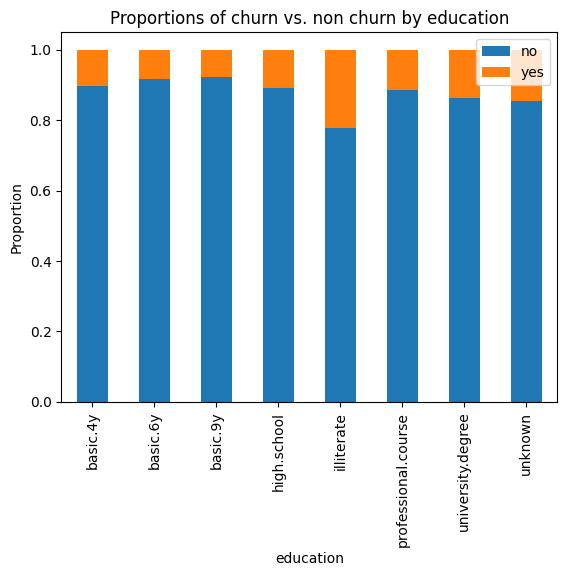

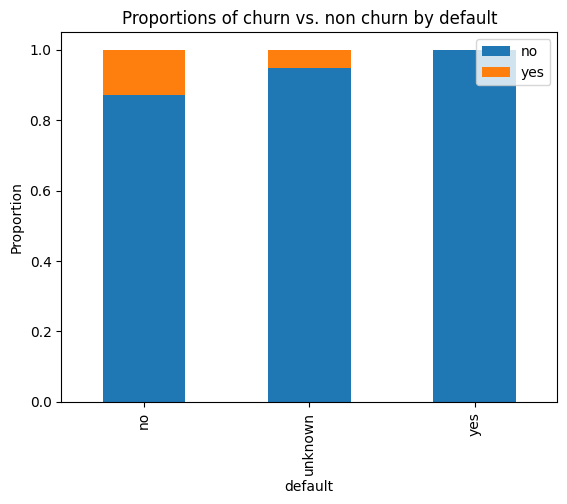

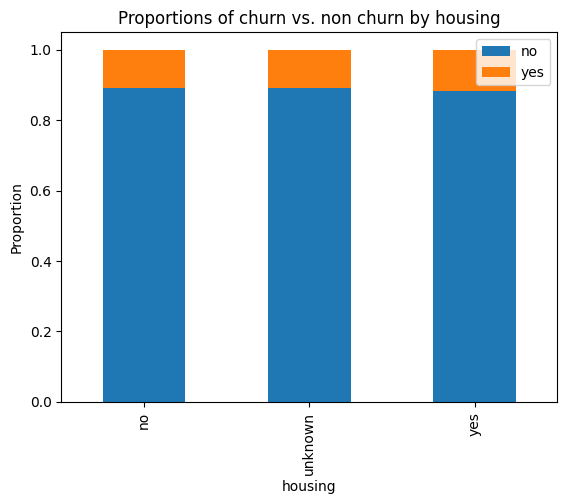

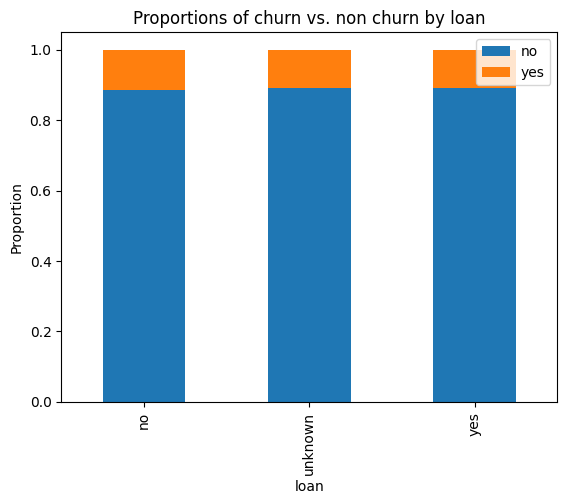

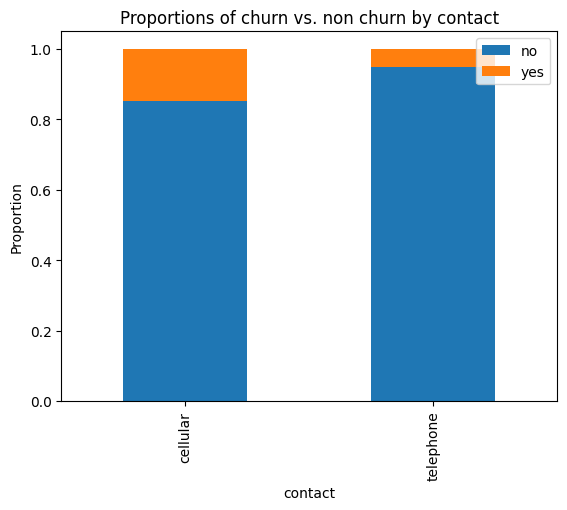

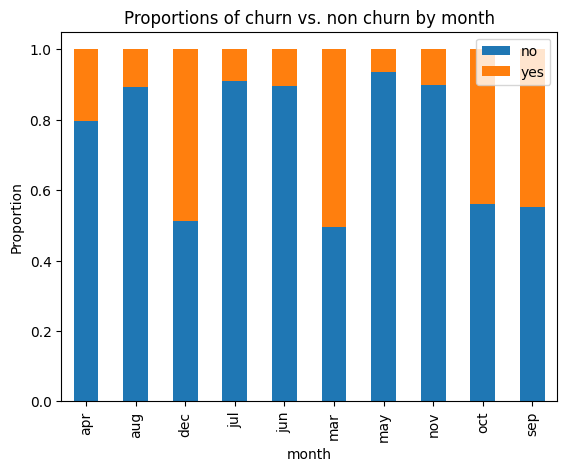

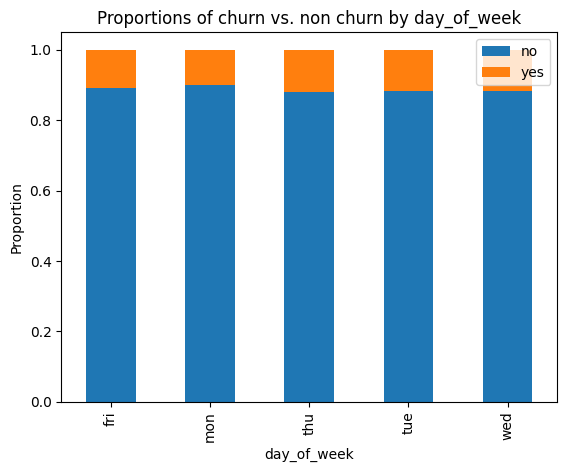

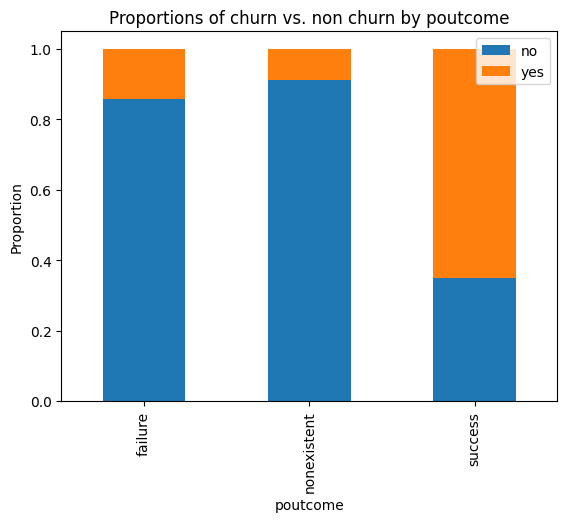

In [9]:
for c in analyzer.summary(df)["features"]["qualitative_columns"]:
    if c != outcome:
        analyzer.prop_churn_by_cats(df,outcome,c)

'job': influence, distributions are not identical
'marital': no influence, identical distributions (almost)
'education': a little influence, variance of proportion of positive people's (y==yes) conditioned by education is low (*)
'default': influence, identical distributions, people who has credit in default don't subscribe bank term deposit
'housing': no influence, identical distributions
'loan': no influence, identical distributions
'contact': influence, distributions are not identical
'month': influence, distributions are not identical
'day_of_week': no influence, identical distributions
'poutcome': influence, distributions are not identical
Conclusion:
'job', 'default', 'contact','month','poutcome' have influence
maybe also a little bit 'education'

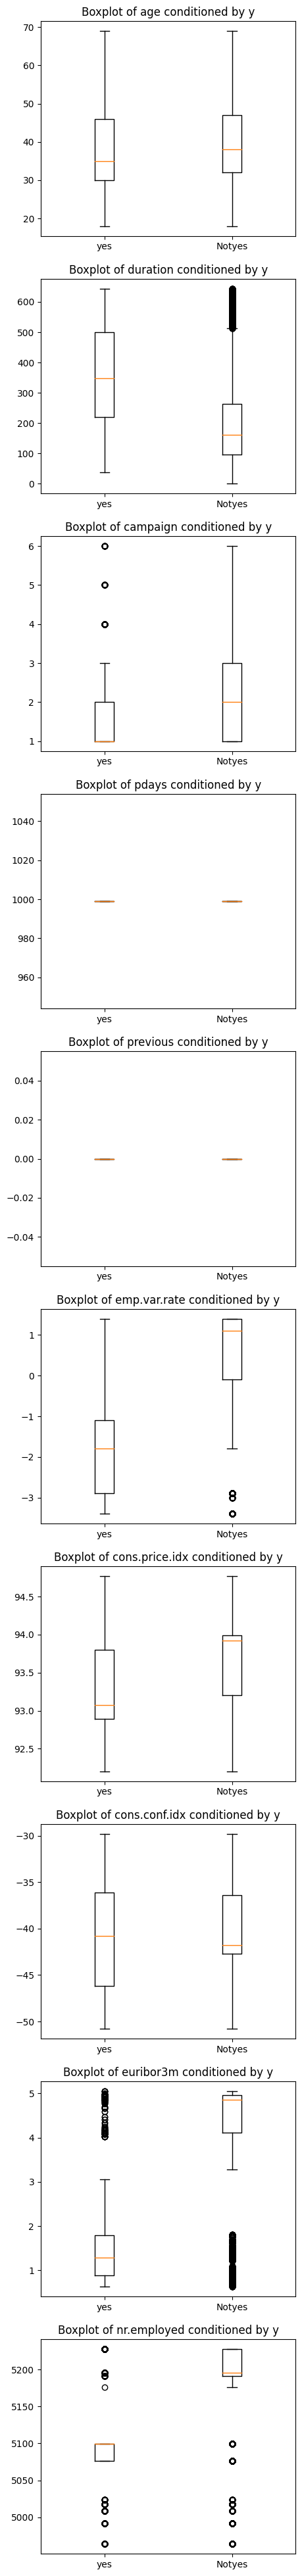

In [10]:
#we decided to remove outliers before boxplots creation
df=process.remove_outliers(df)
fig,axs=plt.subplots(nrows=len(quantitatives),figsize=(5,len(quantitatives)*5))
for i in range(len(quantitatives)):
    analyzer.prop_churn_by_numerical_boxplot(df,outcome,positive_mod,quantitatives[i],axs[i])

'age': a little, little bit influence, distributions seems same (*)
'duration': influence, different median for distributions
'campaign': influence, different median for distributions
'pdays': no influence
'previous': no influence
'emp.var.rate': influence, different median for distributions
'cons.price.idx': influence, different median for distributions
'cons.conf.idx': a little bit influence, quantiles 75% seems be same, but quantile 25% are different (*)
'euribor3m': influence, different median for distributions
'nr.employed': influence, different median for distributions

Conclusion -relevant quantitative features:
duration, campaign, emp.var.rate, cons.price.idx, euribor3m, nr.employed

In [11]:
process.summary(df)

{'Missing Values': age               0
 job               0
 marital           0
 education         0
 default           0
 housing           0
 loan              0
 contact           0
 month             0
 day_of_week       0
 duration          0
 campaign          0
 pdays             0
 previous          0
 poutcome          0
 emp.var.rate      0
 cons.price.idx    0
 cons.conf.idx     0
 euribor3m         0
 nr.employed       0
 y                 0
 dtype: int64,
 'Constant Features': ['pdays', 'previous', 'poutcome']}

In [12]:
relevant_features_quanti=[
    "duration",
    "campaign",
    "emp.var.rate",
    "cons.price.idx",
    "euribor3m",
    "nr.employed"
]
relevant_features_quali=[
    'job',
    'default',
    'contact',
    'month',
    #'poutcome'--->removed
]
#we decided to remove 'poutcome' because when we removed outliers, this feature become constant
relevant_features=relevant_features_quanti+relevant_features_quali
df_new=df[[outcome]+relevant_features] #we decided to work with only relevant features for Attrition

<Axes: >

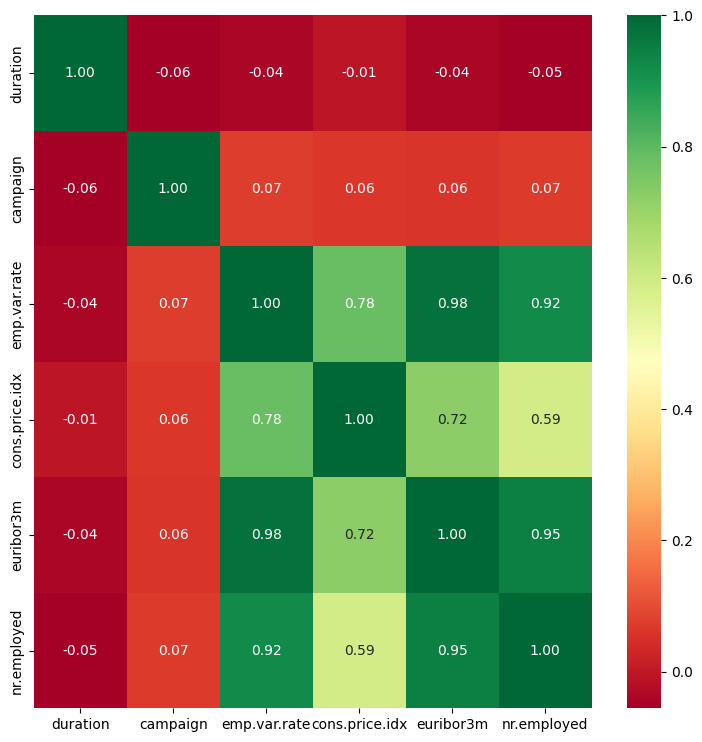

In [13]:
plt.figure(figsize=(9,9))
analyzer.correlation_heatmap(df_new,annot=True)

In [14]:
correlations=df_new.corr(numeric_only=True)
groups={1:.3,2:.6,3:.6}
"""
high correlation (>=.6): group3
medium correlation (>=.3 and <.6): group2
low correlation (<.3):group1
"""
print()

In [15]:
dict_correlations={key:[] for key in groups.keys()}
for group in groups.keys():
    if group==1:
        rows, cols =np.where(np.abs(correlations) < groups[group])
    elif group==2:
        rows, cols =np.where((np.abs(correlations) < groups[group]) & (np.abs(correlations) >= groups[group-1]))
    elif group==3:
        rows, cols =np.where(np.abs(correlations) >= groups[group])
    dict_correlations[group]=[(correlations.index[row], correlations.columns[col], correlations.iloc[row, col]) \
                              for row, col in zip(rows, cols) if row != col]

In [16]:
{
    group_number: dict_correlations[group_number]
        for group_number in dict_correlations.keys()
}

{1: [('duration', 'campaign', -0.05596752026628057),
  ('duration', 'emp.var.rate', -0.04139845947970505),
  ('duration', 'cons.price.idx', -0.009591603989461895),
  ('duration', 'euribor3m', -0.042485205635337975),
  ('duration', 'nr.employed', -0.054803911096615636),
  ('campaign', 'duration', -0.05596752026628057),
  ('campaign', 'emp.var.rate', 0.07374728205006055),
  ('campaign', 'cons.price.idx', 0.060038951903611325),
  ('campaign', 'euribor3m', 0.05723448520849954),
  ('campaign', 'nr.employed', 0.06973038860792087),
  ('emp.var.rate', 'duration', -0.04139845947970505),
  ('emp.var.rate', 'campaign', 0.07374728205006055),
  ('cons.price.idx', 'duration', -0.009591603989461895),
  ('cons.price.idx', 'campaign', 0.060038951903611325),
  ('euribor3m', 'duration', -0.042485205635337975),
  ('euribor3m', 'campaign', 0.05723448520849954),
  ('nr.employed', 'duration', -0.054803911096615636),
  ('nr.employed', 'campaign', 0.06973038860792087)],
 2: [('cons.price.idx', 'nr.employed', 0

We can see that 'emp.var.rate' and 'euribor3m' have very high correlations (~0.97)
'emp.var.rate' and 'nr.employed' have a correlation with .61 in absolute value.
We remove 'emp.var.rate' before training ML models

In [17]:
removed_features=["emp.var.rate"]
relevant_features=[f for f in relevant_features if f not in removed_features]
df_new_=df_new[[outcome]+relevant_features]

In [18]:
process.summary(df_new_)

{'Missing Values': y                 0
 duration          0
 campaign          0
 cons.price.idx    0
 euribor3m         0
 nr.employed       0
 job               0
 default           0
 contact           0
 month             0
 dtype: int64,
 'Constant Features': []}

In [19]:
analyzer.summary(df_new_)

{'features': {'qualitative_columns': ['y',
   'job',
   'default',
   'contact',
   'month'],
  'quantitative_columns': ['duration',
   'campaign',
   'cons.price.idx',
   'euribor3m',
   'nr.employed']},
 'describe':            duration      campaign  cons.price.idx     euribor3m   nr.employed
 count  30360.000000  30360.000000    30360.000000  30360.000000  30360.000000
 mean     204.932576      2.081555       93.646458      3.970239   5181.932372
 std      140.214267      1.302700        0.538624      1.556323     60.639498
 min        0.000000      1.000000       92.201000      0.634000   4963.600000
 25%      100.000000      1.000000       93.200000      4.021000   5191.000000
 50%      167.000000      2.000000       93.918000      4.859000   5195.800000
 75%      277.000000      3.000000       93.994000      4.962000   5228.100000
 max      644.000000      6.000000       94.767000      5.045000   5228.100000}

In [20]:
###END OF SESSION 1

In [21]:
from src.core.ComputeModel import ComputeModel
from src.globals import MODEL_HYPERPARAMETERS_DEF
import copy

positive_mod="yes"
models={"Logistic Regression":None,
        "SVM":None,
        "DecisionTreeClassifier":None
        }

In [22]:
#we use liblinear solver because Gradient descent doesn't converge for Logistic Regression
for model_name in models.keys():
    if model_name == "Logistic Regression":
        hyperparameters=copy.deepcopy(MODEL_HYPERPARAMETERS_DEF[model_name])
        hyperparameters["solver"]="liblinear"
    else:
        hyperparameters=None

    models[model_name]=ComputeModel(
        df_new_[relevant_features],
        df_new_[outcome],
        process=process,
        model_name=model_name,
        hyperparameters=hyperparameters,
        positive_mod=positive_mod
    )
    models[model_name].fit()

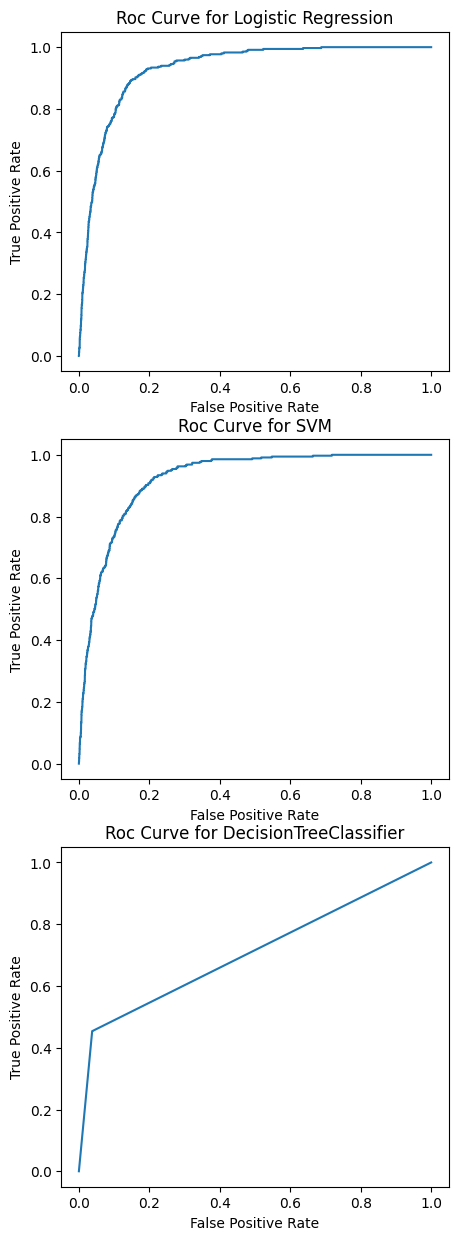

In [23]:
fig,axs = plt.subplots(
    nrows=len(models.keys()),
    figsize=(5,5*len(models.keys()))
)
metrics_default = \
    {
        list(models.keys())[i]:models[list(models.keys())[i]].metrics(plot_roc=True,ax=axs[i]) for i in range(len(models.keys()))
    }

In [24]:
metrics_default

{'Logistic Regression': {'auc': 0.9297104046683855,
  'accuracy': 0.94433465085639,
  'precision': 0.5352112676056338,
  'recall': 0.21839080459770116,
  'f1_score': 0.31020408163265306},
 'SVM': {'auc': 0.9223728784629349,
  'accuracy': 0.9446640316205533,
  'precision': 0.5555555555555556,
  'recall': 0.1724137931034483,
  'f1_score': 0.26315789473684215},
 'DecisionTreeClassifier': {'auc': 0.708000493987807,
  'accuracy': 0.9331357048748353,
  'precision': 0.42245989304812837,
  'recall': 0.4540229885057471,
  'f1_score': 0.43767313019390586}}

In conclusion:
we set up three models, DecisionTreeClassifier, SVM, Logistic Regression:
we use AUC metrics because it's metrics that allow to see False positive Rate and True Positive Rate, and as dataset is imbalanced, accuracy in this case is not relevant
- We can see that  Logistic Regression and SVM  are the best model because auc ~ 0.929 and auc ~0.922 respectively for Logistic Regression and SVM:
  roc curve for 2 models are really good two concave curve with very high auc
- Decision Tree Classifier have 0.710 auc but recall,f1-score are better than 2 others models, implies that probability for a row to be positive (y==yes) are greater than probability for others models. I think Logistic Regression and SVM are as distribution probability with very less probability to be positive for a row
- Simplify conclusion: Logistic Regression > SVM > DecisionTreeClassifier (with default hyperparameters)

In [25]:
distributions_test={model_name:None for model_name in models.keys()}
for model_name in models.keys():
    X_test=models[model_name].dict_split["arrays"]["X_test"]
    distributions_test[model_name]=models[model_name].model.predict_proba(X_test)

In [26]:
params_grid= \
    {
        "Logistic Regression": \
            {
                "penalty": ["l2"],
                "C": np.logspace(-3, 3, 7),
                "solver": ["lbfgs"],
                "multi_class": ["auto"],
                "n_jobs": [None],
                "max_iter": [300,350]
            },
        "SVM":
            {
                "kernel": ["poly", "rbf", "sigmoid"],
                "C": [0.1, 1, 10, 100],
                "degree": [3],
                "gamma": [1, 0.1, 0.01, 0.001]

            },
        "DecisionTreeClassifier":
            {
                "criterion": ["gini"],
                "splitter": ["best"],
                "max_depth": [None],
                "min_samples_split": [2],
                "min_samples_leaf": [1],
                "min_weight_fraction_leaf": [0.],
                "max_features": [None],
                "random_state": [None],
                "max_leaf_nodes": [None],
                "min_impurity_decrease": [0.],
                "class_weight": [None],
                "ccp_alpha": [0.]
            }

    }

In [ ]:
# we used 3 fold cross validation with a params default
# grid located in globals file (in src directory)
for model_name in models.keys():
    models[model_name]=ComputeModel(
        df_new_[relevant_features],
        df_new_[outcome],
        process=process,
        model_name=model_name,
        positive_mod=positive_mod,
        grid_search=True,
        cv=3,
        params_grid=params_grid[model_name]
    )
    models[model_name].fit()

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 48 candidates, totalling 144 fits


In [ ]:
fig,axs=plt.subplots(
    nrows=len(models.keys()),
    figsize=(5,5*len(models.keys()))
)

metrics = {
    list(models.keys())[i]:models[list(models.keys())[i]].metrics(plot_roc=True,ax=axs[i]) for i in range(len(models.keys()))
}

metrics

In [ ]:
resume_tuned=pd.DataFrame(metrics)
resume_default=pd.DataFrame(metrics_default)

In [ ]:
pd.concat(
    [resume_tuned.T,resume_default.T])\
    .reset_index()\
    .groupby("index")\
    .agg(lambda x:[a for a in x]
         )
#first component of tuple is indicator for hyperparameters tuning

- We can see that SVM are significantly improve in term of performance (auc: 0.69 to .99)!, DecisionTreeClassifier stay at the same order of values.
  But with tuning, LogisticRegression, auc stay constant, but precision increase (0.6 to 0.9 after tuning), f1_score and recall decrease a little bit after tuning
- An important things: metrics after tuning are more reliable because a 3 fold cross validation are set up during training whereas with default hyperparameters this 3 cross validation was not done (1 test set and 1 training set), that's why some indicators don't increase after tuning.
- Conclusion: SVM now is better than other models with a very high value for all metrics with cross validation (3 fold cross validation)

In [ ]:
hyperparameters_tuned = {
    list(models.keys())[i]:models[list(models.keys())[i]].model.hyperparameters for i in range(len(models.keys()))
}

In [ ]:
best_model, hyperparameters = models["SVM"], hyperparameters_tuned["SVM"]

In [ ]:
### END OF SESSION 2